In [40]:
from mlflow.tracking.client import MlflowClient
from mlflow.entities import ViewType
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
import os
os.chdir('..')
from scipy.special import softmax
from sklearn.metrics import confusion_matrix, classification_report
from src.utils.model import load_experiment,load_exprerimant_by_id
import torch
from torch.autograd import Variable
from src.experiments.static_quantization import quantize_static
from src.experiments.pruning import model_size
from torch.utils.data import DataLoader, Dataset, random_split

sns.set(color_codes=True)
%matplotlib inline
mlflow.set_tracking_uri("file:/data/logs/kristian/mlruns")
%load_ext autoreload
%autoreload 2
import matplotlib
matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
})

WP = "params.quantization/weight_precision"
AP = "params.quantization/activation_precision"
MODEL = "lenetplus"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
mean = [0.3337, 0.3064, 0.3171] 
std = [0.2672, 0.2564, 0.2629]
mt = torch.FloatTensor(mean).view(3,1,1)
st = torch.FloatTensor(std).view(3,1,1)

def unnormalize(img):
    return img * st + mt


In [42]:
experiments = [
    {'id': "27",  'name': 'resnet18' }, 
    {'id': "24", 'name': 'lenet' }, 
    {'id': "25", 'name': 'lenetplus' },
    {'id': "26",  'name': 'squeezenet' }
]
exp = [m  for m in experiments if m["name"] == MODEL][0]

In [43]:
d = mlflow.search_runs(
    experiment_ids=exp["id"],
    output_format="pandas",
)
if 'train_id' in exp.keys():
    d2 = mlflow.search_runs(
        experiment_ids=exp["train_id"],
        output_format="pandas",
    )
    d = pd.concat([d, d2])

In [44]:
q = d[d["tags.type"] == "quantization"]
q = q[q[AP] == "7"]
q = q[q[WP] == "8"].iloc[0]

pq = d[d["tags.type"] == "pruning + quantization"]
pq = pq[pq[AP] == "7"]
pq = pq[pq[WP] == "8"].iloc[0]

train = d[d["tags.stage"] == "train"].iloc[0]
t_model, datamodule, _ = load_experiment(train["params.hydra/log_dir"])

prun = d[d["tags.pruning_method"] == 'unstructured_l1']
prun = prun[prun["tags.type"] == 'pruning'].iloc[0]
cp = prun["params.model_0.25"]   
if not cp:
    raise Error()
p_model, datamodule, _ = load_experiment(train["params.hydra/log_dir"], compressed_path=cp)

t_model.eval()

print()


Global seed set to 42
Global seed set to 42


In [45]:
def saliency(input, model):
    device = torch.device("cpu:0")
    model.to(device)
    input.to(device)

    for param in model.parameters():
       param.requires_grad = False

    
    input = input.reshape((1,3,32,32))

    model.eval()


    input.requires_grad = True
    preds = model(input)
    score, indices = torch.max(preds, 1)
    # backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    # get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    # normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    return slc.numpy()

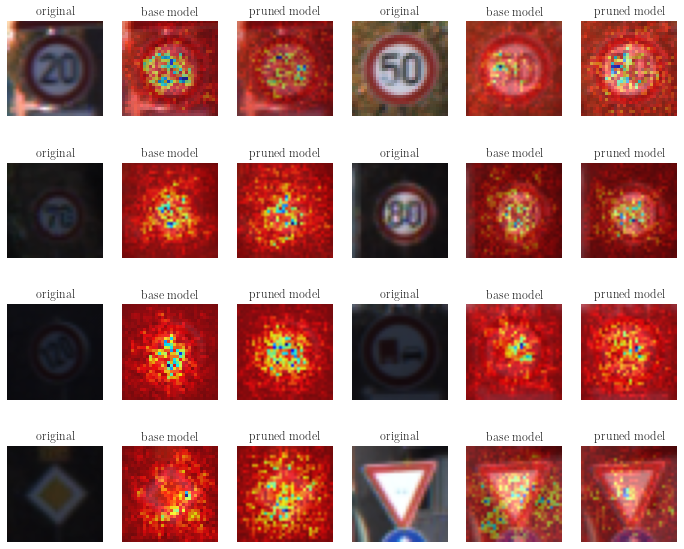

In [46]:
from pytorch_grad_cam.utils.image import show_cam_on_image
test = datamodule.data_test
image = next(iter(test))[0]

fig = plt.figure(figsize=(12,10))

i = 1
for j in range(10):
    if i <= 8:
        image, _ = test.__getitem__(j * 1000)
        slc = saliency(image, t_model)
        slc_p = saliency(image, p_model)


        img = unnormalize(image)
        img = img.numpy()
        img = img.swapaxes(0,1)
        img = img.swapaxes(1,2)

        plt.subplot(4,6, 3*i-2)
        plt.axis('off')
        plt.title("original")
        plt.imshow(img)
        

        plt.subplot(4,6, 3*i-1)
        plt.axis('off')
        plt.title("base model")
        plt.imshow(show_cam_on_image(img, slc))

        plt.subplot(4,6, 3*i)
        plt.axis('off')
        plt.title("pruned model")
        plt.imshow(show_cam_on_image(img, slc_p))
    i += 1
plt.savefig(f'/home/k.schwienbacher/quantization-robustness/data/A_gtsrb/saliency/s-{MODEL}-pfp-cam.jpg')

In [47]:
len(datamodule.data_test)

12630

In [48]:
from tqdm import tqdm
import random

i = 0
slcs = []
slcs_p = []

targs = []
imgs = []
for i in tqdm(range(1000)):
    image, target = test.__getitem__(random.randint(0, 12630))

    

    slc = saliency(image, t_model)
    slc_p = saliency(image, p_model)

    img = unnormalize(image)
    img = img.numpy()
    img = img.swapaxes(0,1)
    img = img.swapaxes(1,2)

    slcs.append(slc)
    slcs_p.append(slc_p)
    targs.append(target)
    imgs.append(img)
  

100%|██████████| 1000/1000 [00:09<00:00, 107.99it/s]


In [49]:
import pickle
data = {"imgs": imgs, "slc": slcs, "targs": targs}
data_p = {"slc": slcs_p}


with open(f"/home/k.schwienbacher/quantization-robustness/data/A_gtsrb/saliency/{MODEL}", "wb") as f:
    pickle.dump(data, f)
with open(f"/home/k.schwienbacher/quantization-robustness/data/A_gtsrb/saliency/{MODEL}-p", "wb") as f:
    pickle.dump(data_p, f)


In [50]:
import pickle
with open(f"/home/k.schwienbacher/quantization-robustness/data/A_gtsrb/saliency/{MODEL}", "rb") as f:
    data = pickle.load(f)
with open(f"/home/k.schwienbacher/quantization-robustness/data/A_gtsrb/saliency/{MODEL}-p", "rb") as f:
    data_p = pickle.load(f)

slcs = data["slc"]
slcs_p = data_p["slc"]
imgs = data["imgs"]
targs = data["targs"]


<AxesSubplot:>

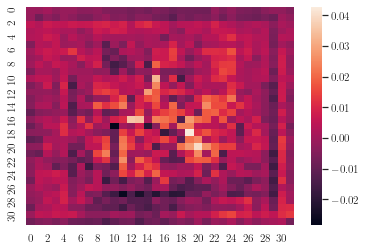

In [51]:
s = np.array(slcs)
sp = np.array(slcs_p)

m = (s-sp)
i = np.argmax(np.abs(m.mean(axis=1).mean(axis=1)))
mse = np.abs(m.mean(axis=1).mean(axis=1))


sns.heatmap(m.mean(axis=0))


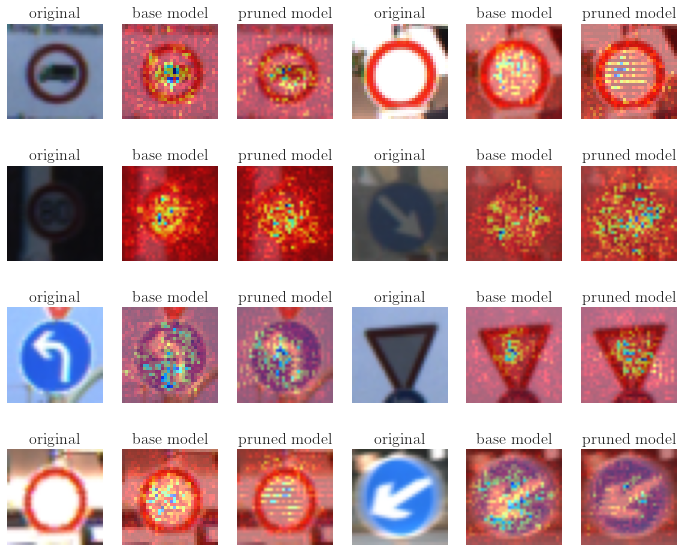

In [52]:
fig = plt.figure(figsize=(12,10))

n = 1
for i in top8:
    plt.subplot(4,6, 3*n-2)
    plt.axis('off')
    plt.title("original", fontsize=16)
    plt.imshow(imgs[i])

    plt.subplot(4,6, 3*n-1)
    plt.axis('off')
    plt.title("base model", fontsize=16)
    plt.imshow(show_cam_on_image(imgs[i], slcs[i]))

    plt.subplot(4,6, 3*n)
    plt.axis('off')
    plt.title("pruned model", fontsize=16)
    plt.imshow(show_cam_on_image(imgs[i], slcs_p[i]))
    n += 1
plt.savefig(f'/home/k.schwienbacher/quantization-robustness/data/A_gtsrb/saliency/s-{MODEL}-top8.pdf', bbox_inches="tight")
